In [1]:
import os
import pandas as pd
import sqlalchemy as sa
import altair as alt
from altair.expr import datum

In [2]:
# we need to run this line to use Altair in a Jupyter notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
ROOT = os.path.abspath(os.path.pardir)
DB_NAME = 'Pokemon.db'
DB_PATH = os.path.abspath(os.path.join(ROOT, DB_NAME))
PLOTS_PATH = os.path.abspath(os.path.join(ROOT, 'plots'))
print(DB_PATH)
print(PLOTS_PATH)

/home/giacomo/repos/reddit-dataviz-battle-2018-09/Pokemon.db
/home/giacomo/repos/reddit-dataviz-battle-2018-09/plots


In [4]:
engine = sa.create_engine(f"sqlite:///{DB_PATH}")

In [7]:
sql = '''
SELECT * FROM pokemons AS p
LIMIT 5
'''
df = pd.read_sql(sql, con=engine)
df

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,None,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,None,19.0,1,0


In [6]:
sql = '''
SELECT
  p.name
FROM pokemons AS p
LIMIT 3
'''
df = pd.read_sql(sql, con=engine)
print(df.shape)
df.head()

(3, 1)


,name
0,Bulbasaur
1,Ivysaur
2,Venusaur


In [12]:
sql = '''
SELECT * FROM pokemons AS p
'''
df = pd.read_sql(sql, con=engine)

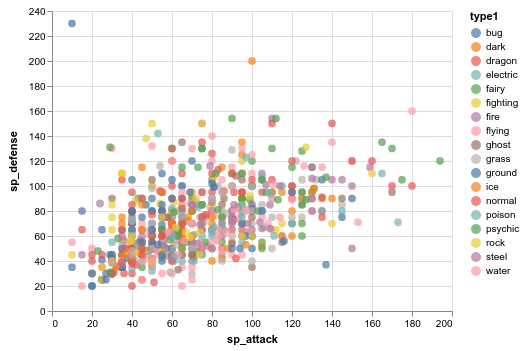

In [13]:
alt.Chart(df).mark_circle(size=60).encode(
    x='sp_attack',
    y='sp_defense',
    color='type1',
    tooltip=['name', 'type1', 'sp_attack', 'sp_defense', 'weight_kg', 'speed', 'is_legendary']
).interactive()